# RL Assignment 05

Roberto Cai Wu / Ramesh Kumar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class BlackJack(object):
    def __init__(self):
        self.r = [1, 0, -1]
        self.a = ['hit', 'stick']
        self.episodes = 1100
        self.N0 = 50
        self.gamma = 1
        self.d_intervals = [[1,4],[4,7],[7,10]]
        self.p_intervals = [[1,6],[4,9],[7,12],[10,15],[13,18],[16,21]]
        
    def draw_card(self):
        card = np.random.randint(1,11)
        if card > 10:
            card = 10
        return card
    
    def check_sum(self, cards):
        ace = False
        total = 0
        for i in range(len(cards)):
            if cards[i] == 1:
                ace = True
            total += cards[i] 
        
        if ace:
            if total < 12:
                total += 10
        
        return total
        
    def deal_to_player(self):
        cards = []
        for i in range(2):
            cards.append(self.draw_card())
        return self.check_sum(cards)
    
    def play_dealer(self, card, player_sum):
        cards = []
        cards.append(card)
        while self.check_sum(cards) < 17:
            cards.append(self.draw_card())
        return self.check_sum(cards)
    
    def start_game(self):
        player_sum = self.deal_to_player()
        dealer_card = self.draw_card()
        return [dealer_card, player_sum]
    
    def advance(self, s, a):
        terminal = False
        if a == 'hit':
            card = self.draw_card()
            if card == 1:
                if s[1] < 11:
                    s[1] += 11
                else:
                    s[1] += 1
            else:
                s[1] += card         
            if s[1] > 21:
                terminal = True
                r = -1
            else: 
                r = 0
        else:
            terminal = True
            dealer_sum = self.play_dealer(s[0],s[1])
            if dealer_sum > s[1]:
                r = -1
            elif dealer_sum == s[1]:
                r = 0
            else:
                r = 1
        return terminal,s,r
    
    def get_greedy_action(self, s):
        greedy_a = np.argmax(self.Q[s[0]-1,s[1]-1,:])
        return greedy_a
    
                
    def sarsa_lambda(self):

        
        l = 0
        l_ind = 0
        rewards = np.zeros(11)
        while l <= 1:
            self.Q = np.zeros([10,21,2])
            self.Ns = np.zeros([10,21])
            self.Nsa = np.zeros([10,21,2])
            self.e = np.zeros([10,21,2])
            acum_reward = 0
            for i in range(1100):
                s = self.start_game()
                a_ind = np.random.randint(0,2)
                self.Ns[s[0]-1, s[1]-1] += 1
                self.Nsa[s[0]-1, s[1]-1, a_ind] += 1
                not_terminal = True
                while not_terminal:
                    terminal,ns,r = self.advance(s,self.a[a_ind])
                    if i >= 1000:
                        acum_reward += r
                        
                    if ns[1] > 21:
                        break
                    
                    if terminal:
                        not_terminal = False
                    
                    epsilon = self.N0 / (self.N0 + self.Ns[ns[0]-1,ns[1]-1])

                    if i < 1000:
                        rand_a = np.random.random()
                        if rand_a < epsilon:
                            na_ind = np.random.randint(0,2)
                        else:
                            na_ind = self.get_greedy_action(ns)
                        
                        self.Ns[ns[0]-1, ns[1]-1] += 1
                        self.Nsa[ns[0]-1, ns[1]-1, na_ind] += 1


                        delta = r + self.Q[ns[0]-1, ns[1]-1, na_ind] - self.Q[s[0]-1, s[1]-1, a_ind]

                        self.e[s[0]-1, s[1]-1, a_ind] += 1


                        alpha = 1/self.Nsa[ns[0]-1, ns[1]-1, na_ind] 

                        self.Q += alpha*delta*self.e
                        self.e = self.gamma*l*self.e



                    else:
                        na_ind = self.get_greedy_action(ns)
                    s = ns
                    a_ind = na_ind
                    
            rewards[l_ind] = acum_reward
            l += 0.1
            l_ind += 1
        l = np.linspace(0, 1, num=11)
        return l,rewards        
    
    def feature_vector(self, s, a):
        features = []
        for i in range(len(self.p_intervals)):
            for j in range(len(self.d_intervals)):
                p = self.p_intervals[i]
                d = self.d_intervals[j]
                if p[0] <= s[1] <= p[1] and d[0] <= s[0] <= d[1]:
                    features.append(1)
                else:
                    features.append(0)

        if a == 'hit':
            return np.concatenate([np.array(features), np.zeros(18)])
        else:
            return np.concatenate([np.zeros(18),np.array(features)])
        
    def value_function_approximator(self):
        l = 0
        l_ind = 0
        rewards = np.zeros(11)
        epsilon = 0.05
        alpha = 0.01
        while l <= 1:
            self.theta = np.random.random(36)*0.5
            acum_reward = 0
            for i in range(1100):
                s = self.start_game()
                a_ind = np.random.randint(0,2)
                self.e = np.zeros(36)
                phi = self.feature_vector(s,self.a[a_ind])
                
                not_terminal = True
                while not_terminal:
                    self.e[phi==1] += 1
                    
                    terminal,ns,r = self.advance(s,self.a[a_ind])
                    if i >= 1000:
                        acum_reward += r
                        
                    if ns[1] > 21:
                        break
                    
                    if terminal:
                        not_terminal = False

                    if i < 1000:
                        delta = r + phi*self.theta.T                 
                        
                        rand_a = np.random.random()
                        if rand_a < 1-epsilon:
                            Qa = float(-100000)
                            for act in range(len(self.a)):
                                phi_curr = self.feature_vector(ns,self.a[act])
                                Q =  sum(self.theta*phi_curr)
                                if Q > Qa:
                                    Qa = Q
                                    na_ind = act
                                    phi = phi_curr
                        else:
                            na_ind = np.random.randint(0,2)
                            phi = self.feature_vector(ns,na_ind)
                            Qa = sum(self.theta*phi)
                        
                        delta += self.gamma*Qa
                        self.theta += alpha*delta*self.e
                        self.e = self.gamma*l*self.e

                    else:
                        Qa = float(-100000)
                        for act in range(len(self.a)):
                            phi_curr = self.feature_vector(ns,self.a[act])
                            Q =  sum(self.theta*phi_curr)
                            if Q > Qa:
                                Qa = Q
                                na_ind = act
                                phi = phi_curr
                    s = ns
                    a_ind = na_ind
                    
            rewards[l_ind] = acum_reward
            l += 0.1
            l_ind += 1
        l = np.linspace(0, 1, num=11)
        return l,rewards 

In [3]:
b = BlackJack()

In [4]:
l,r = b.sarsa_lambda()
r

array([-83., -82., -84., -82., -86., -78., -72., -85., -81., -83., -86.])

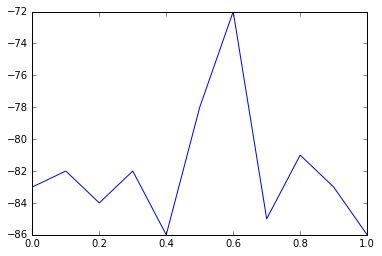

In [5]:
%matplotlib inline
plt.plot(l,r)

In [6]:
l,r = b.value_function_approximator()
r

array([-73., -57., -87., -73., -63., -79., -76., -70., -85., -79., -72.])

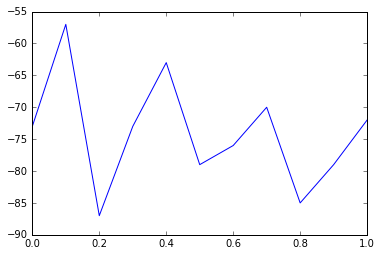

In [7]:
%matplotlib inline
plt.plot(l,r)